# 1. model 생성을 위한 units = 0이 아닌 데이터만 뽑아서 만든다

## 1-1 전체 데이터 load

In [1]:
from jw_package import *
from filling_missing import *
from functools import *

import configuration completed !
train + key + weather merging started
train + key + weather merging finished
function configuration completed ! 
Good to go !


In [2]:
each_station = []

for station_nbr in range(1,21):
    file_path = '../data/weather_best_close_final/{:02}.csv'.format(station_nbr)
    station = pd.read_csv(file_path,index_col=0)
    station.dropna(axis=0,how='any',inplace=True)
    each_station.append(station)

weather = reduce((lambda x,y : x.append(y)),each_station)

In [3]:
sales = pd.read_csv('../data/basic/train.csv')
keys = pd.read_csv('../data/basic/key.csv')

In [4]:
data = sales.merge(keys).merge(weather)

In [5]:
data.head()

,date,store_nbr,item_nbr,units,station_nbr,tmax,tmin,tavg,depart,dewpoint,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,day,codesum
0,2012-01-01,1,1,0,1,52.0,31.0,42.0,10.0,36.0,...,0.05,29.78,29.92,3.6,20.0,4.6,2012,1,1,RA FZFG BR
1,2012-01-01,1,2,0,1,52.0,31.0,42.0,10.0,36.0,...,0.05,29.78,29.92,3.6,20.0,4.6,2012,1,1,RA FZFG BR
2,2012-01-01,1,3,0,1,52.0,31.0,42.0,10.0,36.0,...,0.05,29.78,29.92,3.6,20.0,4.6,2012,1,1,RA FZFG BR
3,2012-01-01,1,4,0,1,52.0,31.0,42.0,10.0,36.0,...,0.05,29.78,29.92,3.6,20.0,4.6,2012,1,1,RA FZFG BR
4,2012-01-01,1,5,0,1,52.0,31.0,42.0,10.0,36.0,...,0.05,29.78,29.92,3.6,20.0,4.6,2012,1,1,RA FZFG BR


## 1-2 tmp 데이터로 copy후 units = 0이 아닌 것만 뽑아서 model 생성

In [6]:
tmp = data.copy()

In [7]:
tmp = tmp[tmp['units']!=0]

In [8]:
etc = ['day','month','year','station_nbr']
category = ['sunrise','sunset','codesum']

for each in etc+category:
    tmp.drop(each,axis=1,inplace=True)

In [9]:
del tmp['tavg']
del tmp['sealevel']
del tmp['wetbulb']
del tmp['stnpressure']
del tmp['tmin']
del tmp['tmax']
del tmp['dewpoint']
del tmp['avgspeed']
del tmp['resultspeed']

In [10]:
tmp.reset_index(drop = True, inplace = True)

In [11]:
tmp.tail()

,date,store_nbr,item_nbr,units,depart,heat,cool,snowfall,preciptotal,resultdir
118659,2014-10-29,35,66,14,6.0,13.0,0.0,0.0,0.02,23.0
118660,2014-10-30,35,16,16,6.0,13.0,0.0,0.0,0.02,30.0
118661,2014-10-30,35,66,6,6.0,13.0,0.0,0.0,0.02,30.0
118662,2014-10-31,35,16,18,2.0,24.0,0.0,0.0,0.00,5.0
118663,2014-10-31,35,66,10,2.0,24.0,0.0,0.0,0.00,5.0


# 2. 이부분은 codesum_v1.csv 데이터 load

In [11]:
codesum = pd.read_csv('../data/weather_v1.csv', index_col = 0)

In [12]:
codesum = codesum.merge(keys, on = 'station_nbr' )

In [13]:
codesum = codesum.loc[:,['date','store_nbr','is_holiday','codesum']]

In [14]:
tmp = tmp.merge(codesum, on = ['date','store_nbr'])

In [16]:
tmp.head()

,date,store_nbr,item_nbr,units,depart,heat,cool,snowfall,preciptotal,resultdir,is_holiday,codesum
0,2012-01-01,1,9,29,10.0,23.0,0.0,0.0,0.05,20.0,holiday,Not_MO
1,2012-01-01,1,28,2,10.0,23.0,0.0,0.0,0.05,20.0,holiday,Not_MO
2,2012-01-01,1,51,1,10.0,23.0,0.0,0.0,0.05,20.0,holiday,Not_MO
3,2012-01-02,1,9,60,23.0,24.0,0.0,0.0,0.01,24.0,holiday_work,MO
4,2012-01-02,1,28,5,23.0,24.0,0.0,0.0,0.01,24.0,holiday_work,MO


## 2-1. codesum에서 holiday 컬럼, codesum 컬럼 category변환 함수 
- holiday 이면 1 아니면 0
- codesum 'Not_MO'이면 1 MO 이면 0 

In [15]:
def cate_holiday(holiday):
    if holiday == 'holiday' or holiday == 'holiday_work':
            return 1
    else:
        return 0
def cate_codesum(codesum):
    if codesum == 'MO':
        return 0 
    else:
        return 1
    
tmp['is_holiday'] = tmp['is_holiday'].apply(cate_holiday)
tmp['codesum'] = tmp['codesum'].apply(cate_codesum)

In [18]:
tmp.head()

,date,store_nbr,item_nbr,units,depart,heat,cool,snowfall,preciptotal,resultdir,is_holiday,codesum
0,2012-01-01,1,9,29,10.0,23.0,0.0,0.0,0.05,20.0,1,1
1,2012-01-01,1,28,2,10.0,23.0,0.0,0.0,0.05,20.0,1,1
2,2012-01-01,1,51,1,10.0,23.0,0.0,0.0,0.05,20.0,1,1
3,2012-01-02,1,9,60,23.0,24.0,0.0,0.0,0.01,24.0,1,0
4,2012-01-02,1,28,5,23.0,24.0,0.0,0.0,0.01,24.0,1,0


# 3. model 생성
- formula = 'units ~ C(store_nbr) + C(item_nbr)+ scale(cool) + scale(heat) + scale(preciptotal) + scale(snowfall) + is_holiday'

In [16]:
formula = 'units ~ C(store_nbr) + C(item_nbr)+ scale(cool) + scale(heat) + scale(preciptotal) + scale(snowfall) + is_holiday'
model = sm.OLS.from_formula(formula, data= tmp)
result = model.fit()

In [30]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  units   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     3129.
Date:                Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                        02:28:00   Log-Likelihood:            -4.3557e+05
No. Observations:              107962   AIC:                         8.715e+05
Df Residuals:                  107802   BIC:                         8.730e+05
Df Model:                         159                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              7.9544      0.960      8.286      0.000       6.073       9.836
C(store_nbr)[T.2]     32.1159      0.570     56.327      0.000      30.998      33.233
C(store_nbr)[T.3]     18.4131      0.530     34.731      0.000      17.374      19.452
C(store_nbr)[T.4]     71.4150      0.732     97.536      0.000      69.980      72.850
C(store_nbr)[T.5]     15.3185      0.560     27.352      0.000      14.221      16.416
C(store_nbr)[T.6]     14.5500      0.538     27.030      0.000      13.495      15.605
C(store_nbr)[T.7]     24.1158      0.596     40.458      0.000      22.948      25.284
C(store_nbr)[T.8]      6.7279      0.576     11.683      0.000       5.599       7.857
C(store_nbr)[T.9]     17.0168      0.533     31.934      0.000      15.972      18.061
C(store_nbr)[T.10]    20.1652      0.537     37.537      0.000      19.112      21.218
C(store_nbr)[T.11]    10.3709      0.524     19.801      0.000       9.344      11.397
C(store_nbr)[T.12]    21.8044      0.554     39.333      0.000      20.718      22.891
C(store_nbr)[T.13]    32.8080      0.579     56.702      0.000      31.674      33.942
C(store_nbr)[T.14]   -30.7846      0.580    -53.050      0.000     -31.922     -29.647
C(store_nbr)[T.15]    23.9403      0.519     46.134      0.000      22.923      24.957
C(store_nbr)[T.16]    33.6176      0.597     56.299      0.000      32.447      34.788
C(store_nbr)[T.17]    70.5779      0.593    119.034      0.000      69.416      71.740
C(store_nbr)[T.18]     1.7144      0.552      3.103      0.002       0.632       2.797
C(store_nbr)[T.19]     9.6355      0.615     15.656      0.000       8.429      10.842
C(store_nbr)[T.20]    26.2304      0.603     43.490      0.000      25.048      27.413
C(store_nbr)[T.21]     3.6502      0.561      6.510      0.000       2.551       4.749
C(store_nbr)[T.22]    13.2023      0.524     25.209      0.000      12.176      14.229
C(store_nbr)[T.23]    -4.7527      0.535     -8.881      0.000      -5.802      -3.704
C(store_nbr)[T.24]    73.8438      2.078     35.532      0.000      69.771      77.917
C(store_nbr)[T.25]    32.3933      0.522     62.055      0.000      31.370      33.416
C(store_nbr)[T.26]     5.0429      0.536      9.406      0.000       3.992       6.094
C(store_nbr)[T.27]     7.5903      0.512     14.821      0.000       6.587       8.594
C(store_nbr)[T.28]     3.0701      0.541      5.677      0.000       2.010       4.130
C(store_nbr)[T.29]    14.7479      0.580     25.448      0.000      13.612      15.884
C(store_nbr)[T.30]    29.0733      0.605     48.083      0.000      27.888      30.258
C(store_nbr)[T.31]    24.7957      0.511     48.536      0.000      23.794      25.797
C(store_nbr)[T.32]     3.6327      0.490      7.414      0.000       2.672       4.593
C(store_nbr)[T.33]    87.3558      0.6

## 3-1. cross validation 확인

In [40]:
X = tmp.loc[:, ['store_nbr', 'item_nbr', 'cool', 'heat', 'preciptotal','snowfall', 'is_holiday']]
y = tmp.loc[:, ['units']]

In [41]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=4, shuffle=True, random_state=0)
for train_index, test_index in cv.split(X):
    print("test index :", test_index, len(test_index))
    print("." * 80)
    print("train index:", train_index, len(train_index))
    print("=" * 80)

    X_train = X.loc[train_index, :]
    X_test = X.loc[test_index, :]
    y_train = y.loc[train_index, :]
    y_test = y.loc[test_index, :]
    
    tmp = pd.concat([X_train, y_train], axis = 1)
    formula = 'units ~ C(store_nbr) + C(item_nbr)+ scale(cool) + scale(heat) + scale(preciptotal) + scale(snowfall) + is_holiday'
    
    model = sm.OLS.from_formula(formula, data= tmp)
    result = model.fit()
    
    
    y_hat = result.predict(X_test)
    
    
    
    print(((y_hat - y_hat.mean())**2).sum()  / ((y_test-y_test.mean())**2).sum() )

test index : [     3      6      9 ..., 118659 118660 118663] 29666
................................................................................
train index: [     0      1      2 ..., 118658 118661 118662] 88998
units    0.460212
dtype: float64
test index : [     1      8     11 ..., 118652 118655 118662] 29666
................................................................................
train index: [     0      2      3 ..., 118660 118661 118663] 88998
units    0.687306
dtype: float64
test index : [     0      4      5 ..., 118642 118653 118658] 29666
................................................................................
train index: [     1      2      3 ..., 118661 118662 118663] 88998
units    0.594435
dtype: float64
test index : [     2     10     13 ..., 118641 118649 118661] 29666
................................................................................
train index: [     0      1      3 ..., 118660 118662 118663] 88998
units    0.698335
dtype: float64


# 4. Outlier 제거 코드

In [31]:
res = result.resid_pearson
index = result.resid.index
outlier_index = abs(res) >= 2

row = pd.Series(index=index, data=res)
drop_index = row[outlier_index].index
len(drop_index)

tmp.drop(list(drop_index),inplace=True)
tmp.reset_index(drop = True, inplace = True)

X = tmp.loc[:, ['date', 'store_nbr', 'item_nbr', 'cool', 'heat', 'preciptotal','snowfall', 'is_holiday']]
y = tmp.loc[:, ['units']]

In [32]:
len(tmp)

115397

## 4-1. 2차 제거 후 cross_val 확인
- 위 코드 두번 실행

In [44]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=4, shuffle=True, random_state=0)
for train_index, test_index in cv.split(X):
    print("test index :", test_index, len(test_index))
    print("." * 80)
    print("train index:", train_index, len(train_index))
    print("=" * 80)

    X_train = X.loc[train_index, :]
    X_test = X.loc[test_index, :]
    y_train = y.loc[train_index, :]
    y_test = y.loc[test_index, :]
    
    formula = 'units ~ C(store_nbr) + C(item_nbr)+ scale(cool) + scale(heat) + scale(preciptotal) + scale(snowfall) + is_holiday'
    
    model = sm.OLS.from_formula(formula, data= pd.concat([X_train, y_train], axis = 1))
    result = model.fit()
    
    y_hat = result.predict(X_test)
    
    print(((y_hat - y_hat.mean())**2).sum()  / ((y_test-y_test.mean())**2).sum() )

test index : [    1     3     9 ..., 75608 75609 75612] 18904
................................................................................
train index: [    0     2     4 ..., 75607 75610 75611] 56709
units    0.849638
dtype: float64
test index : [    0     5     6 ..., 75606 75607 75611] 18903
................................................................................
train index: [    1     2     3 ..., 75609 75610 75612] 56710
units    0.870567
dtype: float64
test index : [    4     7     8 ..., 75594 75605 75610] 18903
................................................................................
train index: [    0     1     2 ..., 75609 75611 75612] 56710
units    0.859694
dtype: float64
test index : [    2    10    13 ..., 75599 75600 75601] 18903
................................................................................
train index: [    0     1     3 ..., 75610 75611 75612] 56710
units    0.875258
dtype: float64


# 4-2. 현재모델

In [ ]:
'units ~ C(store_nbr) + C(item_nbr)+ scale(cool) + scale(heat) + scale(preciptotal) + scale(snowfall) + is_holiday'

In [33]:
formula = 'units ~ C(store_nbr) + C(item_nbr)+ cool + heat + preciptotal + snowfall + is_holiday'

In [34]:
model = sm.OLS.from_formula(formula, data= tmp)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  units   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     2361.
Date:                Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                        03:04:19   Log-Likelihood:            -4.9916e+05
No. Observations:              115397   AIC:                         9.986e+05
Df Residuals:                  115237   BIC:                         1.000e+06
Df Model:                         159                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             10.0005      1.270      7.876      0.000       7.512      12.489
C(store_nbr)[T.2]     32.0864      0.725     44.252      0.000      30.665      33.508
C(store_nbr)[T.3]     20.1540      0.689     29.250      0.000      18.804      21.504
C(store_nbr)[T.4]     69.8664      0.833     83.900      0.000      68.234      71.499
C(store_nbr)[T.5]     20.2657      0.735     27.556      0.000      18.824      21.707
C(store_nbr)[T.6]     15.6161      0.697     22.398      0.000      14.250      16.983
C(store_nbr)[T.7]     26.9989      0.764     35.324      0.000      25.501      28.497
C(store_nbr)[T.8]      7.6392      0.752     10.153      0.000       6.165       9.114
C(store_nbr)[T.9]     17.7155      0.696     25.463      0.000      16.352      19.079
C(store_nbr)[T.10]    25.0145      0.698     35.845      0.000      23.647      26.382
C(store_nbr)[T.11]    10.1151      0.689     14.691      0.000       8.766      11.465
C(store_nbr)[T.12]    26.8716      0.728     36.929      0.000      25.445      28.298
C(store_nbr)[T.13]    34.0772      0.745     45.714      0.000      32.616      35.538
C(store_nbr)[T.14]   -30.4016      0.724    -41.981      0.000     -31.821     -28.982
C(store_nbr)[T.15]    27.1925      0.669     40.644      0.000      25.881      28.504
C(store_nbr)[T.16]    44.3203      0.764     58.024      0.000      42.823      45.817
C(store_nbr)[T.17]    78.7217      0.740    106.360      0.000      77.271      80.172
C(store_nbr)[T.18]     3.1752      0.727      4.369      0.000       1.751       4.600
C(store_nbr)[T.19]    14.1559      0.809     17.488      0.000      12.569      15.742
C(store_nbr)[T.20]    29.9171      0.771     38.778      0.000      28.405      31.429
C(store_nbr)[T.21]     0.8712      0.723      1.205      0.228      -0.546       2.288
C(store_nbr)[T.22]    13.3241      0.685     19.455      0.000      11.982      14.666
C(store_nbr)[T.23]    -5.6004      0.703     -7.962      0.000      -6.979      -4.222
C(store_nbr)[T.24]    73.0805      2.712     26.945      0.000      67.765      78.396
C(store_nbr)[T.25]    36.5303      0.665     54.924      0.000      35.227      37.834
C(store_nbr)[T.26]     5.9616      0.700      8.513      0.000       4.589       7.334
C(store_nbr)[T.27]     8.0020      0.674     11.873      0.000       6.681       9.323
C(store_nbr)[T.28]     3.4209      0.708      4.830      0.000       2.033       4.809
C(store_nbr)[T.29]    15.5339      0.758     20.486      0.000      14.048      17.020
C(store_nbr)[T.30]    38.8922      0.762     51.025      0.000      37.398      40.386
C(store_nbr)[T.31]    24.5259      0.663     36.996      0.000      23.227      25.825
C(store_nbr)[T.32]     3.5538      0.645      5.510      0.000       2.290       4.818
C(store_nbr)[T.33]    85.6754      0.7

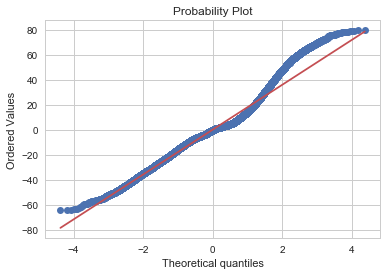

In [35]:
sp.stats.probplot(result.resid, plot=plt)
plt.show()

In [36]:
test = sms.omni_normtest(result.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       : 10716.170
P-value     :  0.000


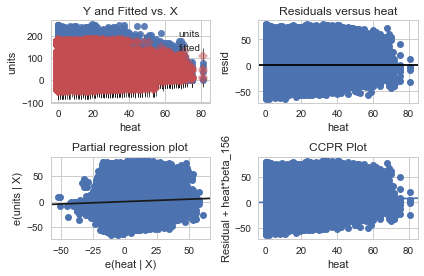

In [37]:
fig = sm.graphics.plot_regress_exog(result, "heat")
fig.suptitle("")
plt.show()

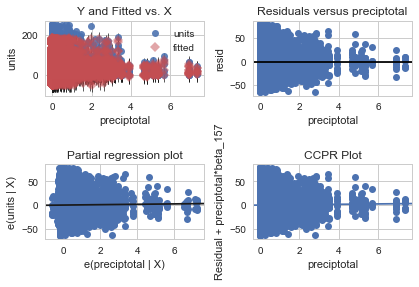

In [38]:
fig = sm.graphics.plot_regress_exog(result, "preciptotal")
fig.suptitle("")
plt.show()

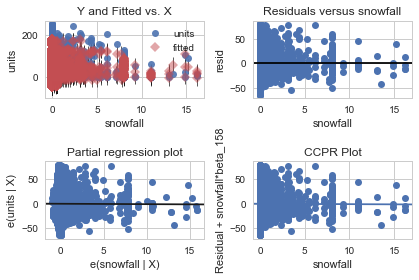

In [39]:
fig = sm.graphics.plot_regress_exog(result, "snowfall")
fig.suptitle("")
plt.show()

# 5. test.csv load

In [56]:
test = pd.read_csv('../data/basic/test.csv', index_col = 0)

In [57]:
test.reset_index(inplace = True)

In [58]:
test.tail()

,date,store_nbr,item_nbr
526912,2014-10-26,45,107
526913,2014-10-26,45,108
526914,2014-10-26,45,109
526915,2014-10-26,45,110
526916,2014-10-26,45,111


## 5-1. test 데이터에 weather's feature merge후 test_df로 저장

In [59]:
test_df = test.merge(keys).merge(weather)

In [60]:
test_df.tail()

,date,store_nbr,item_nbr,station_nbr,tmax,tmin,tavg,depart,dewpoint,wetbulb,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,day,codesum
526912,2014-08-02,40,107,13,81.0,51.0,66.0,3.0,47.0,56.0,...,0.0,24.44,30.12,5.7,17.0,6.5,2014,8,2,
526913,2014-08-02,40,108,13,81.0,51.0,66.0,3.0,47.0,56.0,...,0.0,24.44,30.12,5.7,17.0,6.5,2014,8,2,
526914,2014-08-02,40,109,13,81.0,51.0,66.0,3.0,47.0,56.0,...,0.0,24.44,30.12,5.7,17.0,6.5,2014,8,2,
526915,2014-08-02,40,110,13,81.0,51.0,66.0,3.0,47.0,56.0,...,0.0,24.44,30.12,5.7,17.0,6.5,2014,8,2,
526916,2014-08-02,40,111,13,81.0,51.0,66.0,3.0,47.0,56.0,...,0.0,24.44,30.12,5.7,17.0,6.5,2014,8,2,


In [61]:
etc = ['day','month','year', 'tavg', 'sealevel', 'wetbulb', 'stnpressure', 'tmin', 'tmax', 'dewpoint', 'avgspeed', 'resultspeed']
category = ['sunrise','sunset','codesum']

for each in etc+category:
    test_df.drop(each,axis=1,inplace=True)

In [62]:
test_df.tail()

,date,store_nbr,item_nbr,station_nbr,depart,heat,cool,snowfall,preciptotal,resultdir
526912,2014-08-02,40,107,13,3.0,0.0,1.0,0.0,0.0,17.0
526913,2014-08-02,40,108,13,3.0,0.0,1.0,0.0,0.0,17.0
526914,2014-08-02,40,109,13,3.0,0.0,1.0,0.0,0.0,17.0
526915,2014-08-02,40,110,13,3.0,0.0,1.0,0.0,0.0,17.0
526916,2014-08-02,40,111,13,3.0,0.0,1.0,0.0,0.0,17.0


In [63]:
test_df = test_df.merge(codesum, on = ['date','store_nbr'])
test_df['is_holiday'] = test_df['is_holiday'].apply(cate_holiday)
test_df['codesum'] = test_df['codesum'].apply(cate_codesum)

## 5-2. test_df에서 팔린 units의 feature에 대해서만 선택후 test_X_df에 저장

In [64]:
test_X_df = pd.DataFrame(columns=['date', 'store_nbr', 'item_nbr', 'station_nbr', 'cool', 'depart', 'heat', 'preciptotal', 'resultdir', 'snowfall', 'is_holiday', 'codesum'])

for nbr in range(1, 45+1):
    store_nbr = tmp[tmp['store_nbr'].isin([nbr])]
    sold_item_list = list(store_nbr['item_nbr'].unique())
    sold_item_list

    test_store_nbr = test_df[test_df['store_nbr'].isin([nbr])]
    to_test_df = test_store_nbr[test_store_nbr['item_nbr'].isin(sold_item_list)]

    test_X_df = pd.concat([test_X_df, to_test_df], axis = 0)
    
test_X_df.shape

(25267, 12)

In [65]:
test_X_df.head()

,codesum,cool,date,depart,heat,is_holiday,item_nbr,preciptotal,resultdir,snowfall,station_nbr,store_nbr
484301,0,0.0,2013-06-04,9.0,3.0,0,9,0.0,31.0,0.0,1,1
484320,0,0.0,2013-06-04,9.0,3.0,0,28,0.0,31.0,0.0,1,1
484332,0,0.0,2013-06-04,9.0,3.0,0,40,0.0,31.0,0.0,1,1
484339,0,0.0,2013-06-04,9.0,3.0,0,47,0.0,31.0,0.0,1,1
484343,0,0.0,2013-06-04,9.0,3.0,0,51,0.0,31.0,0.0,1,1


In [66]:
test_X_df.head()

,codesum,cool,date,depart,heat,is_holiday,item_nbr,preciptotal,resultdir,snowfall,station_nbr,store_nbr
484301,0,0.0,2013-06-04,9.0,3.0,0,9,0.0,31.0,0.0,1,1
484320,0,0.0,2013-06-04,9.0,3.0,0,28,0.0,31.0,0.0,1,1
484332,0,0.0,2013-06-04,9.0,3.0,0,40,0.0,31.0,0.0,1,1
484339,0,0.0,2013-06-04,9.0,3.0,0,47,0.0,31.0,0.0,1,1
484343,0,0.0,2013-06-04,9.0,3.0,0,51,0.0,31.0,0.0,1,1


## 5-3. test_df와 type을 맞춰줘야함 그래야 predict()에 넣을 수 있다.

In [67]:
test_X_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25267 entries, 484301 to 514074
Data columns (total 12 columns):
codesum        25267 non-null object
cool           25267 non-null float64
date           25267 non-null object
depart         25267 non-null float64
heat           25267 non-null float64
is_holiday     25267 non-null object
item_nbr       25267 non-null object
preciptotal    25267 non-null float64
resultdir      25267 non-null float64
snowfall       25267 non-null float64
station_nbr    25267 non-null object
store_nbr      25267 non-null object
dtypes: float64(6), object(6)
memory usage: 2.5+ MB


In [68]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 526917 entries, 0 to 526916
Data columns (total 12 columns):
date           526917 non-null object
store_nbr      526917 non-null int64
item_nbr       526917 non-null int64
station_nbr    526917 non-null int64
depart         526917 non-null float64
heat           526917 non-null float64
cool           526917 non-null float64
snowfall       526917 non-null float64
preciptotal    526917 non-null float64
resultdir      526917 non-null float64
is_holiday     526917 non-null int64
codesum        526917 non-null int64
dtypes: float64(6), int64(5), object(1)
memory usage: 52.3+ MB


In [69]:
test_X_df['store_nbr'] = test_X_df['store_nbr'].astype(int)
test_X_df['item_nbr'] = test_X_df['item_nbr'].astype(int)
test_X_df['station_nbr'] = test_X_df['station_nbr'].astype(int)
test_X_df['is_holiday'] = test_X_df['is_holiday'].astype(int)
test_X_df['codesum'] = test_X_df['codesum'].astype(int)

## 5-4. 이제 test_X_df 를 predict() 하면

In [70]:
y_hat = result.predict(test_X_df)

In [71]:
y_df = test_df.loc[:,['date','store_nbr','item_nbr']]

In [72]:
y_df['units'] = y_hat

In [73]:
y_df.tail()

,date,store_nbr,item_nbr,units
526912,2014-08-02,40,107,NaN
526913,2014-08-02,40,108,NaN
526914,2014-08-02,40,109,NaN
526915,2014-08-02,40,110,NaN
526916,2014-08-02,40,111,NaN


In [74]:
def itiszero(units):
    if units > 0:
        return units
    else:
        return 0

In [75]:
y_df['units'] = y_df['units'].apply(itiszero)

In [76]:
y_df['units'] = y_df['units'].astype(int)

In [77]:
y_df

,date,store_nbr,item_nbr,units
0,2013-04-01,2,1,0
1,2013-04-01,2,2,0
2,2013-04-01,2,3,0
3,2013-04-01,2,4,0
4,2013-04-01,2,5,51
5,2013-04-01,2,6,0
6,2013-04-01,2,7,0
7,2013-04-01,2,8,0
8,2013-04-01,2,9,0
9,2013-04-01,2,10,0


# 6. 제출 형식에 맞게 수정 후 .csv파일로 저장

In [78]:
y_df['id'] = y_df['store_nbr'].astype(str)+"_"+y_df['item_nbr'].astype(str)+'_'+y_df['date'].astype(str)

In [79]:
for_submission = y_df.loc[:,['id','units']]

In [80]:
for_submission.head()

,id,units
0,2_1_2013-04-01,0
1,2_2_2013-04-01,0
2,2_3_2013-04-01,0
3,2_4_2013-04-01,0
4,2_5_2013-04-01,51


In [81]:
for_submission.to_csv('best_close_submission.csv', index = False)